# Natural Language Processing

## Предварителная обработка текстов

### Задача: Классификация твитов по тональности

In [4]:
# Загружаем данные:
# !wget https://raw.githubusercontent.com/maryszmary/netology_nlp_2021/master/sem1/tweets_sentiment.csv

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression

import nltk
from nltk import tokenize
from nltk import ngrams
from nltk.tokenize import word_tokenize, toktok, sent_tokenize
from nltk.stem.snowball import RussianStemmer
from nltk.corpus import stopwords

from rusenttokenize import ru_sent_tokenize

from pymorphy3 import MorphAnalyzer

In [6]:
df = pd.read_csv('datas/tweets_sentiment.csv')
df.head()

,text,label
0,мыс на меня обиделась:(\nя ей даже ничего не с...,negative
1,"аааааааааааааааааааа,не хочу на работу :(",negative
2,"У меня какой-то особенный вид ушей! :D, некото...",positive
3,@simonovkon он неплохой человек в жизни. Я ра...,negative
4,"RT @Darina_Lo: Домааааа\nЕхали на такси, пели ...",positive


In [7]:
# делим данные на обучающую и тестовую выборки
x_train, x_test, y_train, y_test = train_test_split(df.text, df.label)

In [8]:
print(df.shape)
print(x_train.shape)
print(x_test.shape)

(226834, 2)
(170125,)
(56709,)


In [9]:
# рассмотрим тексты поближе:
df.text.head().tolist()

['мыс на меня обиделась:(\nя ей даже ничего не сделала:(',
 'аааааааааааааааааааа,не хочу на работу :(',
 'У меня какой-то особенный вид ушей! :D, некоторые вакуумные наушники в моих ушах просто не держатся!',
 '@simonovkon  он неплохой человек в жизни. Я работала в шоу-бизе, со многими знакома. Встречаются очень хорошие люди. И не очень(((',
 'RT @Darina_Lo: Домааааа\nЕхали на такси, пели песни, отдыхали.\nКричали на улице:)\nМы настоящяя семья)']

## Векторизация

### CountVectorizer

Самый простой способ извлечь фичи из текстовых данных -- векторизаторы: `CountVectorizer` и `TfidfVectorizer`

Объект `CountVectorizer` делает простую вещь:
* строит для каждого документа (каждой пришедшей ему строки) вектор размерности `n`, где `n` -- количество слов или n-грам во всём корпусе
* заполняет каждый i-тый элемент количеством вхождений слова в данный документ

In [10]:
vec = CountVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(x_train)

В `vec.vocabulary_` лежит словарь: мэппинг слов к их индексам:

In [11]:
list(vec.vocabulary_.items())[:20]

[('даже', 122954),
 ('пришла', 195051),
 ('пораньше', 189483),
 ('вот', 114738),
 ('парикмахера', 178977),
 ('еще', 130556),
 ('нет', 167592),
 ('красота', 148969),
 ('прическа', 194979),
 ('обожаю', 170937),
 ('снег', 212124),
 ('особенно', 174923),
 ('когда', 145922),
 ('хлопьями', 233596),
 ('rt', 74439),
 ('kopitsova', 47430),
 ('тут', 224564),
 ('за', 132233),
 ('соседним', 213907),
 ('столом', 216825)]

#### Создаем N-граммы с помощью NLTK

In [12]:
sent = 'Harry Potter and the Methods of Rationality'.split()
list(ngrams(sent, 1)) # униграммы

[('Harry',),
 ('Potter',),
 ('and',),
 ('the',),
 ('Methods',),
 ('of',),
 ('Rationality',)]

In [13]:
list(ngrams(sent, 2)) # биграммы

[('Harry', 'Potter'),
 ('Potter', 'and'),
 ('and', 'the'),
 ('the', 'Methods'),
 ('Methods', 'of'),
 ('of', 'Rationality')]

In [14]:
list(ngrams(sent, 3)) # триграммы

[('Harry', 'Potter', 'and'),
 ('Potter', 'and', 'the'),
 ('and', 'the', 'Methods'),
 ('the', 'Methods', 'of'),
 ('Methods', 'of', 'Rationality')]

#### Классифицируем вектроизованный текст `bow`

In [15]:
bow

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 1849557 stored elements and shape (170125, 243731)>

In [16]:
clf = LogisticRegression(random_state=42, solver='liblinear')
clf.fit(bow, y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [17]:
vec.transform(x_test)

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 561171 stored elements and shape (56709, 243731)>

In [18]:
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.77      0.76      0.76     28348
    positive       0.76      0.77      0.77     28361

    accuracy                           0.76     56709
   macro avg       0.76      0.76      0.76     56709
weighted avg       0.76      0.76      0.76     56709



#### Как работает `fit_transform` векторизатора?

In [19]:
vec_mini = CountVectorizer()

In [20]:
corpus = [
    'в Минске сегодня снег', 
    'в Минске холодно и сыро',
    'снег это хорошо, но холодно',
]

In [21]:
vec_mini.fit(corpus)

CountVectorizer()

In [22]:
vec_mini.vocabulary_

{'минске': 0,
 'сегодня': 2,
 'снег': 3,
 'холодно': 5,
 'сыро': 4,
 'это': 7,
 'хорошо': 6,
 'но': 1}

In [39]:
vec_mini.get_feature_names_out()

array(['минске', 'но', 'сегодня', 'снег', 'сыро', 'холодно', 'хорошо',
       'это'], dtype=object)

In [23]:
matrix = vec_mini.transform(corpus)

In [24]:
matrix.todense()

matrix([[1, 0, 1, 1, 0, 0, 0, 0],
        [1, 0, 0, 0, 1, 1, 0, 0],
        [0, 1, 0, 1, 0, 1, 1, 1]])

In [25]:
matrix = vec_mini.transform(['в Минске живут слоны'])
matrix.todense()

matrix([[1, 0, 0, 0, 0, 0, 0, 0]])

### TF-IDF веторизация

In [26]:
vec = TfidfVectorizer()
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42, solver='liblinear')
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.73      0.77      0.75     26800
    positive       0.78      0.75      0.76     29909

    accuracy                           0.76     56709
   macro avg       0.76      0.76      0.76     56709
weighted avg       0.76      0.76      0.76     56709



## Токенизация

Токенизировать -- значит, поделить текст на слова, или *токены*.

Самый наивный способ токенизировать текст -- разделить с помощью `split`. Но `split` упускает очень много всего, например, банально не отделяет пунктуацию от слов. Кроме этого, есть ещё много менее тривиальных проблем.

In [29]:
df.text.iloc[0].split()

['мыс',
 'на',
 'меня',
 'обиделась:(',
 'я',
 'ей',
 'даже',
 'ничего',
 'не',
 'сделала:(']

In [38]:
vec.get_feature_names_out()[20:40]

array(['002', '003', '004anna', '004hafarf4', '005', '0060', '007',
       '0080', '008ge0nygh', '008novublr', '009', '009_panda',
       '00_katusha', '00_orekhova', '00c6a95bst', '00darya', '00dwpheuip',
       '00gorbunova', '00lg6bsnb8', '00ngi3vmps'], dtype=object)

#### Использование библиотеки nltk

[Анализ тектовых данных с помощью NLTK и Python](https://habr.com/ru/companies/otus/articles/774498/)

##### word_tockenize

In [57]:
# При первом использовании nltk восзикает ошибка: Lookup error
# Надо выполнить код:
# import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /home/andrew/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [55]:
example = "Но не каждый хочет что-то исправлять:("
word_tokenize(example)

['Но', 'не', 'каждый', 'хочет', 'что-то', 'исправлять', ':', '(']

In [56]:
text = u'Is 9.5 or 525,600 my favorit number?'
word_tokenize(text, language='english', preserve_line=False)

['Is', '9.5', 'or', '525,600', 'my', 'favorit', 'number', '?']

##### В nltk много токенизаторов

In [59]:
dir(tokenize)[:16]

['BlanklineTokenizer',
 'LegalitySyllableTokenizer',
 'LineTokenizer',
 'MWETokenizer',
 'NLTKWordTokenizer',
 'PunktSentenceTokenizer',
 'PunktTokenizer',
 'RegexpTokenizer',
 'ReppTokenizer',
 'SExprTokenizer',
 'SpaceTokenizer',
 'StanfordSegmenter',
 'SyllableTokenizer',
 'TabTokenizer',
 'TextTilingTokenizer',
 'ToktokTokenizer']

In [61]:
len(dir(tokenize))

61

##### ToktokTockenizer

In [63]:
toktok = toktok.ToktokTokenizer()
text = u'Is 9.5 or 525,600 my favorite number?'
print(toktok.tokenize(text))

['Is', '9.5', 'or', '525,600', 'my', 'favorite', 'number', '?']


In [64]:
print(toktok.tokenize(example))

['Но', 'не', 'каждый', 'хочет', 'что-то', 'исправлять', ':', '(']


##### WhitespaceTokenizer

In [65]:
wh_tok = tokenize.WhitespaceTokenizer()

Разбивает текст по пробелама:

In [68]:
print(wh_tok.tokenize(example))

['Но', 'не', 'каждый', 'хочет', 'что-то', 'исправлять:(']


Умеет выдавать индексы начала и конца каждого токена:

In [66]:
list(wh_tok.span_tokenize(example))

[(0, 2), (3, 5), (6, 12), (13, 18), (19, 25), (26, 38)]

##### TreebanWordTokenizer

In [69]:
tokenize.TreebankWordTokenizer().tokenize("don't stop me")

['do', "n't", 'stop', 'me']

Отделил `n't` от `do`

##### SExprTokenizer

In [71]:
tokenize.SExprTokenizer().tokenize("(a (b c)) d e (f)")

['(a (b c))', 'd', 'e', '(f)']

### Частотные слова

Знаки препинания можно достать из встроенной библиотеки `string`

In [72]:
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
from collections import Counter

# Составляем список всех слов в корпусе
corpus = [token for tweet in df.text for token in word_tokenize(tweet) if token not in punctuation]
print(len(corpus))
corpus[:10]

2870536


['мыс',
 'на',
 'меня',
 'обиделась',
 'я',
 'ей',
 'даже',
 'ничего',
 'не',
 'сделала']

In [76]:
# Составим частотный словарь:
freq_dict = Counter(corpus)
freq_dict.most_common(20)

[('не', 69472),
 ('и', 55166),
 ('в', 52902),
 ('я', 52818),
 ('RT', 38070),
 ('на', 35759),
 ('http', 32998),
 ('что', 31541),
 ('с', 27217),
 ('а', 26860),
 ('...', 22363),
 ('меня', 20656),
 ('у', 18928),
 ('как', 18280),
 ('так', 16839),
 ('D', 16575),
 ('это', 16542),
 ('мне', 16337),
 ('все', 14763),
 ('ты', 13412)]

### Закон Ципфа

In [90]:
freq_dict

Counter({'не': 69472,
         'и': 55166,
         'в': 52902,
         'я': 52818,
         'RT': 38070,
         'на': 35759,
         'http': 32998,
         'что': 31541,
         'с': 27217,
         'а': 26860,
         '...': 22363,
         'меня': 20656,
         'у': 18928,
         'как': 18280,
         'так': 16839,
         'D': 16575,
         'это': 16542,
         'мне': 16337,
         'все': 14763,
         'ты': 13412,
         'но': 12949,
         "''": 12470,
         'Я': 12315,
         '``': 11468,
         'то': 11433,
         '..': 11392,
         'по': 11294,
         'уже': 10180,
         'за': 10038,
         'же': 9628,
         'ну': 8742,
         'А': 8635,
         'только': 8065,
         'бы': 8041,
         'еще': 7829,
         'да': 7413,
         'вот': 7244,
         'тебя': 7161,
         'нет': 7078,
         'когда': 6676,
         'очень': 6436,
         'сегодня': 6377,
         'будет': 6368,
         'к': 6357,
         'день': 6332,

In [93]:
freqs = list(freq_dict.values())
freqs

[2,
 35759,
 20656,
 87,
 52818,
 882,
 4683,
 2998,
 69472,
 555,
 4,
 6137,
 801,
 3520,
 547,
 16,
 165,
 43,
 16575,
 212,
 2,
 182,
 52902,
 494,
 20,
 6052,
 8,
 6,
 6064,
 33,
 1225,
 1479,
 12315,
 41,
 1,
 2971,
 13,
 15,
 1,
 6436,
 256,
 1415,
 5308,
 38070,
 1,
 1,
 7,
 73,
 52,
 457,
 9,
 1,
 967,
 959,
 1,
 139,
 3,
 16542,
 758,
 16839,
 1,
 1,
 3847,
 3,
 10038,
 251,
 1494,
 6368,
 15,
 7,
 27217,
 1,
 60,
 4,
 1112,
 62,
 208,
 87,
 6,
 1,
 1,
 1,
 3,
 84,
 114,
 40,
 1,
 470,
 4051,
 2,
 1,
 5,
 2676,
 5,
 2,
 3,
 6,
 7,
 3,
 1,
 29,
 61,
 55,
 55166,
 66,
 49,
 1,
 654,
 8,
 602,
 7,
 1,
 363,
 2617,
 8635,
 11433,
 2219,
 6,
 12,
 2741,
 1,
 2241,
 508,
 12,
 7244,
 14763,
 9628,
 1201,
 1,
 58,
 1,
 1421,
 1366,
 643,
 2,
 1,
 7,
 1,
 232,
 1016,
 2629,
 697,
 7,
 430,
 1596,
 150,
 26860,
 213,
 22,
 297,
 1155,
 4655,
 127,
 2641,
 221,
 22363,
 447,
 124,
 538,
 8,
 166,
 474,
 16,
 1,
 18928,
 6,
 639,
 8065,
 1167,
 396,
 8,
 7413,
 3270,
 11294,
 17,
 150,
 

In [94]:
freqs = sorted(freqs, reverse=True)
freqs

[69472,
 55166,
 52902,
 52818,
 38070,
 35759,
 32998,
 31541,
 27217,
 26860,
 22363,
 20656,
 18928,
 18280,
 16839,
 16575,
 16542,
 16337,
 14763,
 13412,
 12949,
 12470,
 12315,
 11468,
 11433,
 11392,
 11294,
 10180,
 10038,
 9628,
 8742,
 8635,
 8065,
 8041,
 7829,
 7413,
 7244,
 7161,
 7078,
 6676,
 6436,
 6377,
 6368,
 6357,
 6332,
 6137,
 6064,
 6052,
 5654,
 5484,
 5436,
 5414,
 5406,
 5308,
 5142,
 5063,
 4749,
 4731,
 4723,
 4683,
 4655,
 4494,
 4464,
 4442,
 4319,
 4192,
 4159,
 4056,
 4051,
 4049,
 3971,
 3960,
 3855,
 3847,
 3818,
 3792,
 3747,
 3520,
 3519,
 3511,
 3417,
 3358,
 3270,
 3261,
 3144,
 3116,
 3099,
 3080,
 3008,
 2998,
 2971,
 2923,
 2846,
 2795,
 2793,
 2780,
 2752,
 2741,
 2720,
 2698,
 2677,
 2676,
 2667,
 2641,
 2641,
 2629,
 2617,
 2598,
 2594,
 2562,
 2480,
 2478,
 2469,
 2451,
 2411,
 2386,
 2370,
 2353,
 2320,
 2269,
 2243,
 2241,
 2234,
 2219,
 2213,
 2103,
 2089,
 2080,
 2050,
 2047,
 2025,
 2011,
 1999,
 1951,
 1926,
 1916,
 1898,
 1896,
 1889

Визуализация частот токенов на графике

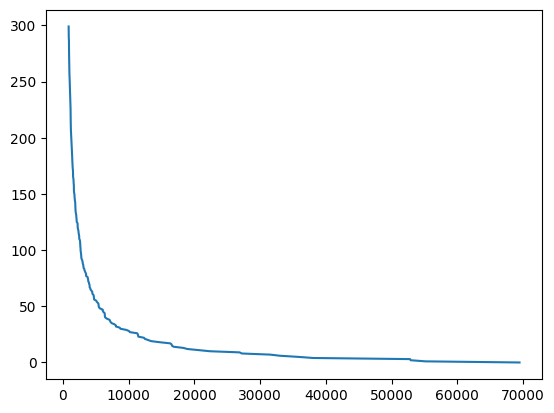

In [95]:
fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.show()

### Закон Хипса

In [96]:
from tqdm import tqdm

In [98]:
cnt = Counter()
n_words = []
n_tokens = []
tokens = []
for index, row in tqdm(df.iterrows(), total=len(df)):
    tokens = word_tokenize(row['text'])
    cnt.update([token for token in tokens if token not in punctuation])
    n_words.append(len(cnt))
    n_tokens.append(sum(cnt.values()))

  0%|          | 43/226834 [00:00<08:51, 427.03it/s]

100%|██████████| 226834/226834 [09:41<00:00, 390.03it/s]


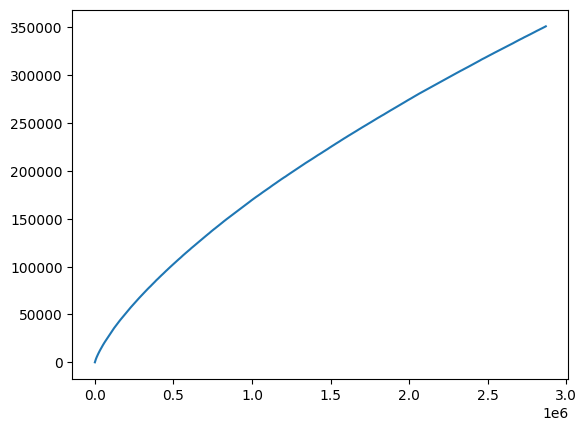

In [100]:
fig, ax = plt.subplots()
ax.plot(n_tokens, n_words)
plt.show()

### Стоп-слова и пунктуация

Используем библиотеку nltk

In [102]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/andrew/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [103]:
print(stopwords.words('russian'))

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [104]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [105]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Соединяем пунктуацию и стоп-слова вместе:
noise = stopwords.words('russian') + list(punctuation)

Используем niose (стоп-слова и знаки пунктуации) как аргумент для CountVectoriser

In [107]:
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words=noise)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

/home/andrew/Netology_NLP/nlp/venv/lib64/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/andrew/Netology_NLP/nlp/venv/lib64/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  warnings.warn(
/home/andrew/Netology_NLP/nlp/venv/lib64/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_

              precision    recall  f1-score   support

    negative       0.80      0.77      0.78     29226
    positive       0.76      0.79      0.78     27483

    accuracy                           0.78     56709
   macro avg       0.78      0.78      0.78     56709
weighted avg       0.78      0.78      0.78     56709



## Лемматизация

### Pymorphy

In [111]:
pymorphy3_analyzer = MorphAnalyzer()

In [112]:
ana = pymorphy3_analyzer.parse('белок')
ana

[Parse(word='белок', tag=OpencorporaTag('NOUN,inan,masc sing,nomn'), normal_form='белок', score=0.4, methods_stack=((DictionaryAnalyzer(), 'белок', 141, 0),)),
 Parse(word='белок', tag=OpencorporaTag('NOUN,anim,femn plur,gent'), normal_form='белка', score=0.2, methods_stack=((DictionaryAnalyzer(), 'белок', 40, 8),)),
 Parse(word='белок', tag=OpencorporaTag('NOUN,anim,femn plur,accs'), normal_form='белка', score=0.2, methods_stack=((DictionaryAnalyzer(), 'белок', 40, 10),)),
 Parse(word='белок', tag=OpencorporaTag('NOUN,inan,masc sing,accs'), normal_form='белок', score=0.2, methods_stack=((DictionaryAnalyzer(), 'белок', 141, 3),))]

In [113]:
ana[0].normal_form

'белок'

In [114]:
ana[0].tag

OpencorporaTag('NOUN,inan,masc sing,nomn')

In [115]:
ana[0].tag.POS

'NOUN'

Функция лемматизации с испльзованием pymorphy:

In [116]:
def lemmatize(text):
    tokens = word_tokenize(text)
    for i, token in enumerate(tokens):
        tokens[i] = pymorphy3_analyzer.parse(token)[0].normal_form
    return tokens    

In [117]:
lemmatize('в минске красивые дома, но очень холодный снег')

['в', 'минск', 'красивый', 'дом', ',', 'но', 'очень', 'холодный', 'снег']

In [118]:
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=lemmatize, stop_words=noise)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

/home/andrew/Netology_NLP/nlp/venv/lib64/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/andrew/Netology_NLP/nlp/venv/lib64/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``', 'большой', 'весь', 'всё', 'ещё', 'мочь', 'нибыть', 'свой', 'хороший', 'это'] not in stop_words.
  warnings.warn(
/home/andrew/Netology_NLP/nlp/venv/lib64/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

              precision    recall  f1-score   support

    negative       0.79      0.76      0.78     29364
    positive       0.75      0.79      0.77     27345

    accuracy                           0.77     56709
   macro avg       0.77      0.77      0.77     56709
weighted avg       0.77      0.77      0.77     56709



## Стемминг

In [120]:
stemmer = RussianStemmer()
words = ['расположение', 'приставить', 'сделала', 'словообразование']
for w in words:
    stem = stemmer.stem(w)
    print(stem)

расположен
пристав
сдела
словообразован


In [122]:
def stemming(text):
    tokens = word_tokenize(text)
    for i, token in enumerate(tokens):
        tokens[i] = stemmer.stem(token)
    return tokens

In [123]:
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=stemming, stop_words=noise)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

/home/andrew/Netology_NLP/nlp/venv/lib64/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/andrew/Netology_NLP/nlp/venv/lib64/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``', 'бол', 'больш', 'будт', 'быт', 'вед', 'впроч', 'всег', 'всегд', 'даж', 'друг', 'е', 'ег', 'ем', 'есл', 'ест', 'ещ', 'зач', 'зде', 'ил', 'иногд', 'когд', 'конечн', 'куд', 'лучш', 'межд', 'мен', 'мног', 'мо', 'можн', 'нег', 'нельз', 'нибуд', 'никогд', 'нич', 'опя', 'посл', 'пот', 'почт', 'разв', 'сво', 'себ', 'совс', 'теб', 'тепер', 'тог', 'тогд', 'тож', 'тольк', 'хорош', 'хот', 'чег', 'чут', 'эт'] not in stop_words.
  warnings.warn(
/home/andrew/Netology_NLP/nlp/venv/lib64/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarn

              precision    recall  f1-score   support

    negative       0.79      0.77      0.78     28953
    positive       0.77      0.79      0.78     27756

    accuracy                           0.78     56709
   macro avg       0.78      0.78      0.78     56709
weighted avg       0.78      0.78      0.78     56709



## Эксплоративный анализ

In [124]:
cool_token = ')'
pred = ['positive' if cool_token in tweet else 'negative' for tweet in x_test]
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       1.00      0.85      0.92     33013
    positive       0.83      1.00      0.91     23696

    accuracy                           0.91     56709
   macro avg       0.91      0.93      0.91     56709
weighted avg       0.93      0.91      0.91     56709



## Символьные n-граммы

In [125]:
vec = CountVectorizer(analyzer='char', ngram_range=(1, 1))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.99      1.00      1.00     27992
    positive       1.00      0.99      1.00     28717

    accuracy                           1.00     56709
   macro avg       1.00      1.00      1.00     56709
weighted avg       1.00      1.00      1.00     56709



## Сегментация предложений

Будем использовать библиотеку `rusenttokenize` и метод `nltk`: `sent_tokenize`

In [129]:
text = 'Эта шоколадка за 400р. ничего из себя не представляла. В г. 2019 Артём решил больше не ходить в этот магазин на берегу р. Москвы.'

In [130]:
sents = sent_tokenize(text)
print(len(sents))
print(*sents, sep='\n')

print()
sents = ru_sent_tokenize(text)

print(len(sents))
print(*sents, sep='\n')

4
Эта шоколадка за 400р.
ничего из себя не представляла.
В г.
2019 Артём решил больше не ходить в этот магазин на берегу р. Москвы.

3
Эта шоколадка за 400р. ничего из себя не представляла.
В г. 2019 Артём решил больше не ходить в этот магазин на берегу р.
Москвы.
